In [14]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import json 

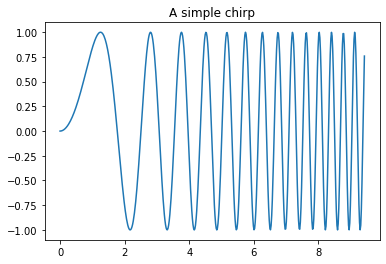

In [3]:
#Checking that plotlib works
x = np.linspace(0, 3*np.pi, 500)
plt.plot(x, np.sin(x**2))
plt.title('A simple chirp')
plt.show()

In [4]:
import scipy.sparse as ss
from scipy.sparse.linalg import expm

sx = ss.csc_matrix([[0, 1],[1,0]], dtype=complex)
sy = ss.csc_matrix([[0, -1j],[1j,0]], dtype=complex)
sz = ss.csc_matrix([[1, 0],[0,-1]], dtype=complex)
Hadamard = ss.csc_matrix([[1, 1],[1,-1]], dtype=complex)/np.sqrt(2)
I2 = ss.identity(2,format='csc')

def add_op(ops, sites, N):
    '''Function creates a global operator on N qubits
    Inputs:
    ops (list of matrices): operators which are not identity
    sites (list of integers): ops[i] acts on sites[i]
    N: size of the chain
    Outputs: operator on the entire system'''
    
    l = [I2 for i in range(N)]
    for s in range(len(sites)): l[sites[s]] = ops[s]
    mat = l[0]
    for i in range(1,N):
        mat = ss.kron(mat, l[i])
    return mat
    
def mydist(size): 
    ws = np.random.randint(0, high=2, size=size)
    xs = []
    for i in range(size):
        if ws[i]==0:
            xs.append(np.random.normal(loc=-np.pi, scale=0.1))
        else: 
            xs.append(np.random.normal(loc=np.pi, scale=0.1))
    return np.array(xs)

def Perceptron_U(N,dt,Js=None, hs=None): 
    if Js is None: Js = np.random.uniform(-np.pi, np.pi, size=N-1)
    if hs is None: hs = np.random.uniform(0, 2*np.pi, size=2)
    
    H = ss.csc_matrix((2**N,2**N), dtype=complex)
    
    for i in range(N-1): 
        H += add_op([-1j*dt*Js[i]*sz, sz],[i,-1], N)
    
    H += add_op([-1j*dt*hs[0]*sz-1j*dt*hs[1]*sx],[-1], N)
    
    return expm(H)

def single_qubit_rotations(N, axis='x', width=1.): 
    ths = np.random.uniform(low=0, high=width*2*np.pi, size=N)
    if axis == 'x':return add_op([expm(-1j*ths[i]*sx) for i in range(N)], np.arange(N), N)
    elif axis == 'z': return add_op([expm(-1j*ths[i]*sz) for i in range(N)], np.arange(N), N)
    elif axis == 'y': return add_op([expm(-1j*ths[i]*sy) for i in range(N)], np.arange(N), N)
    else: raise ValueError('Rotation not supported')

def prepare_OTOC_circuit(N, L, M, O, psi0, dt=1, axes = [['x',1.], ['z',1.]]): 
    U = ss.identity(2**N, format='csc')
    
    for i in range(L):
        #U @= add_op([Hadamard]*N, np.arange(N), N)
        for j in range(len(axes)):
            U @= single_qubit_rotations(N, axis=axes[j][0], width=axes[j][1])
        U @= Perceptron_U(N, dt)
        for j in range(len(axes)):
            U @= single_qubit_rotations(N, axis=axes[j][0], width=axes[j][1])

    Ud = U.conj().T
    A = U@O@Ud@M
    return psi0@(A@A)@psi0.T

In [5]:
#Parameters
N=4
L=50

#Initial state
psi0 = ss.csc_matrix([1]+[0]*(2**N-1))

#Local pauli's 
O = add_op([sz]+[I2]*(N-1), range(N), N)
M = add_op([I2]*(N-2)+[sz, I2], range(N), N)

#Otoc operator
np.real(prepare_OTOC_circuit(N, L, M, O, psi0, dt=0.1).data)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


array([-0.08252772])

In [7]:
import json 

Nsamples=4
Last_L=16
Ls = [i for i in range(Last_L+1)]
otocs = np.zeros((Last_L+1, Nsamples))

dic = {'N': N, 'Ls': Ls, 'Nsamples': Nsamples}
for l in tqdm(Ls): 
    for s in range(Nsamples): 
        otocs[l, s] = np.real(prepare_OTOC_circuit(N, l, M, O, psi0, dt=1).data)
    
    with open('OTOC_data_N4_XZX.json', 'w') as ofile:
        dic['last L'] = l
        dic['data'] = otocs.tolist()
        json.dump(dic, ofile)

  0%|                                                                                           | 0/17 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [00:41<00:00,  2.44s/it]


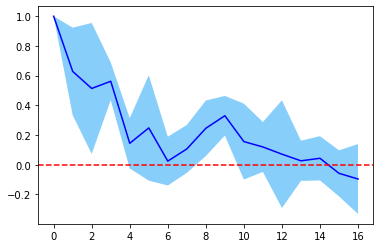

In [8]:
plt.figure()
plt.plot(Ls, np.mean(otocs, axis=1), color='blue')
plt.fill_between(Ls, np.mean(otocs, axis=1)-np.std(otocs, axis=1),np.mean(otocs, axis=1)+np.std(otocs, axis=1), facecolor='lightskyblue')
plt.axhline(y=-1/(2**(2**N)-1), color='r', linestyle='--')
plt.show()

In [11]:
import json 
#Initial state
N=5
psi0 = ss.csc_matrix([1]+[0]*(2**N-1))

#Local pauli's 
O = add_op([sz]+[I2]*(N-1), range(N), N)
M = add_op([I2]*(N-2)+[sz, I2], range(N), N)

Nsamples=4
Last_L=25
Ls = [i for i in range(Last_L+1)]
otocs = np.zeros((Last_L+1, Nsamples))

dic = {'N': N, 'Ls': Ls, 'Nsamples': Nsamples}
for l in tqdm(Ls): 
    for s in range(Nsamples): 
        otocs[l, s] = np.real(prepare_OTOC_circuit(N, l, M, O, psi0, dt=1).data)
    
    with open('OTOC_data_N5_XZX.json', 'w') as ofile:
        dic['last L'] = l
        dic['data'] = otocs.tolist()
        json.dump(dic, ofile)

  0%|                                                                                           | 0/26 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [01:54<00:00,  4.40s/it]


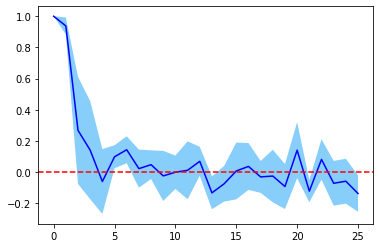

In [13]:
plt.figure()
plt.plot(Ls, np.mean(otocs, axis=1), color='blue')
plt.fill_between(Ls, np.mean(otocs, axis=1)-np.std(otocs, axis=1),np.mean(otocs, axis=1)+np.std(otocs, axis=1), facecolor='lightskyblue')
plt.axhline(y=-1/(2**(2**N)-1), color='r', linestyle='--')
plt.show()

In [6]:
def prepare_OTOC2_circuit(N, L, M1, O1,M2,O2, psi0, dt=1, axes = [['x',1.], ['z',1.]]): 
    U = ss.identity(2**N, format='csc')
    
    for i in range(L):
        #U @= add_op([Hadamard]*N, np.arange(N), N)
        for j in range(len(axes)):
            U @= single_qubit_rotations(N, axis=axes[j][0], width=axes[j][1])
        U @= Perceptron_U(N, dt)
        for j in range(len(axes)):
            U @= single_qubit_rotations(N, axis=axes[j][0], width=axes[j][1])

    Ud = U.conj().T
    A = U@O2@Ud@M2@U@O1@Ud@M1
    return psi0@(A@A)@psi0.T

In [12]:
#Parameters
N=5
L=10

#Initial state
psi0 = ss.csc_matrix([1]+[0]*(2**N-1))

#Local pauli's 
O1 = add_op([sz]+[I2]*(N-1), range(N), N)
M1 = add_op([I2]*(N-2)+[sz, I2], range(N), N)
O2 = add_op([I2, sz]+[I2]*(N-2), range(N), N)
M2 = add_op([I2]*(N-3)+[sz, I2,I2], range(N), N)

#Otoc operator
np.real(prepare_OTOC2_circuit(N, L, M1, O1, M2, O2, psi0, dt=1).data)

array([-0.06516984])

In [15]:
Nsamples=4
Last_L=16
Ls = [i for i in range(Last_L+1)]
otoc2s = np.zeros((Last_L+1, Nsamples))

dic = {'N': N, 'Ls': Ls, 'Nsamples': Nsamples}
for l in tqdm(Ls): 
    for s in range(Nsamples): 
        otoc2s[l, s] = np.real(prepare_OTOC2_circuit(N, l, M1, O1, M2, O2, psi0, dt=1).data)
    
    with open('OTOC2_data_N5_XZX.json', 'w') as ofile:
        dic['last L'] = l
        dic['data'] = otoc2s.tolist()
        json.dump(dic, ofile)

100%|██████████████████████████████████████████████████████████████████████████████████| 17/17 [01:02<00:00,  3.69s/it]


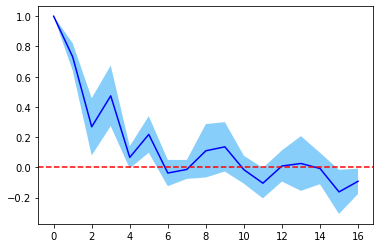

In [17]:
plt.figure()
plt.plot(Ls, np.mean(otoc2s, axis=1), color='blue')
plt.fill_between(Ls, np.mean(otoc2s, axis=1)-np.std(otoc2s, axis=1),np.mean(otoc2s, axis=1)+np.std(otoc2s, axis=1), facecolor='lightskyblue')
plt.axhline(y=-1/(2**(2**N)-1), color='r', linestyle='--')
plt.show()